In [2]:
# -1-) Notlar
"""
    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.

    Yapilmasi gerekenler:
        - merged_all_week - month dict'i mean() alinarak hesaplaniyor, bunlari gercek min max ile ayarla
        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis
        - Farkli grafikler cikartmaya calis.
        - ML.
        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka
        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.

    Sorunlar:
        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun
        ortalamasi az olur. Burada farkli bir yontem bul.
        Mesela gunluk toplami almak olabilir.
        Gunluk maks min alinabilir
"""
# 1-) read and preproccess train.csv
# 2-) extract ilce and keep preprocessing train.csv
# 3-) read and preprocess weather.csv
# 4-) read and preprocess holidays.csv
# 5-) merge the train data and holidays, return a new dict called dict_holiday
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli ve gerekli degil)
# 10-) test icin birlestirme islemleri

"\n    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.\n\n    Yapilmasi gerekenler:\n        - Bu grafiklere trend tahmin gibi şeyler uygulamaya calis\n        - Farkli grafikler cikartmaya calis.\n        - ML.\n        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka\n        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.\n\n    Sorunlar:\n        - Weather'da degerler gunluk ortalama seklinde. 1 saat firtina olsa sonra tum gun yagmur yagmasa o gunun\n        ortalamasi az olur. Burada farkli bir yontem bul.\n        Mesela gunluk toplami almak olabilir.\n        Gunluk maks min alinabilir\n"

In [3]:
# 0-) Import required moduls and libraries

# bildirimisiz_sum tahmin edilecek

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import os
from unidecode import unidecode # to convert Turkish characters to English
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#import tensorflow as tf 
#from keras.models import Sequential 
#from keras.layers import Flatten 
#from keras.layers import Dense 
#from keras.layers import Activation
#from keras.layers import LSTM

In [4]:
# 1-) read and preproccess train.csv
train = pd.read_csv("./train.csv", low_memory=False) # 46.944 satir, 4 kolon

#print(train["tarih"]) # 1.098 farkli tarih var, 47 farkli ilce var

tarihler = []
for i in train["tarih"]:
    tarihler.append(datetime.strptime(i, "%Y-%m-%d"))
train["tarih"] = tarihler

# print(train.dtypes)

dict :{str, pd.DataFrame} = {} # key olarak ilceleri, value olarak o ilcenin verisi (1096 gun) df olarak tutar
for label, group in train.groupby("ilce"):
    dict[label] = group
print(dict["izmir-konak"])
ilceler = (list(dict.keys()))
#print(dict.keys()) # keys olarak her ilceyi, values olarak o ilcelerin bulundugu satirlari icerir

           tarih         ilce  bildirimsiz_sum  bildirimli_sum
30436 2021-01-01  izmir-konak                9               0
30437 2021-01-02  izmir-konak                5               0
30438 2021-01-03  izmir-konak                5               0
30439 2021-01-04  izmir-konak               11               0
30440 2021-01-05  izmir-konak               11               0
...          ...          ...              ...             ...
31527 2023-12-30  izmir-konak               10               1
31528 2023-12-31  izmir-konak                9               0
31529 2024-01-01  izmir-konak               11               0
31530 2024-01-02  izmir-konak                9               1
31531 2024-01-03  izmir-konak                8               1

[1096 rows x 4 columns]


In [5]:
# 2-) extract ilce and keep preprocessing train.csv
"""
for label in dict.keys(): # her ilce icin bildirimsiz ve bildirimli olarak grafiklerini cikart
    print(dict[label]["bildirimsiz_sum"])
    plt.figure(figsize=(14,6))
    plt.bar(dict[label]["tarih"],dict[label]["bildirimsiz_sum"])
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()
"""
"""
plt.figure(figsize=(14,6))
plt.bar(dict["izmir-konak"]["tarih"],dict["izmir-konak"]["bildirimsiz_sum"])
plt.title(label)
plt.margins(0.01)
plt.xticks(rotation=90)
plt.show()
"""
# ilce tarih sayilarini al hepsinde esit veri yok
ilce_tarih_sayilari = {}
for name in dict.keys():
    ilce_tarih_sayilari[name] = len(list(dict[name]["tarih"].to_dict().values()))

print(ilce_tarih_sayilari)
for name in dict.keys():
    dict[name].set_index("tarih", inplace=True)

# train.set_index("tarih", inplace=True) # train'in tarih kolonunu indexe cevir
# print(train)

{'izmir-aliaga': 1078, 'izmir-balcova': 681, 'izmir-bayindir': 1078, 'izmir-bayrakli': 1059, 'izmir-bergama': 1092, 'izmir-beydag': 658, 'izmir-bornova': 1096, 'izmir-buca': 1087, 'izmir-cesme': 1097, 'izmir-cigli': 1044, 'izmir-dikili': 1091, 'izmir-foca': 1058, 'izmir-gaziemir': 898, 'izmir-guzelbahce': 835, 'izmir-karabaglar': 1072, 'izmir-karaburun': 1063, 'izmir-karsiyaka': 1057, 'izmir-kemalpasa': 1091, 'izmir-kinik': 889, 'izmir-kiraz': 1069, 'izmir-konak': 1096, 'izmir-menderes': 1097, 'izmir-menemen': 1091, 'izmir-narlidere': 758, 'izmir-odemis': 1096, 'izmir-seferihisar': 1086, 'izmir-selcuk': 853, 'izmir-tire': 1079, 'izmir-torbali': 1096, 'izmir-urla': 1094, 'manisa-ahmetli': 600, 'manisa-akhisar': 1098, 'manisa-alasehir': 1091, 'manisa-demirci': 918, 'manisa-golmarmara': 555, 'manisa-gordes': 1033, 'manisa-kirkagac': 925, 'manisa-koprubasi': 781, 'manisa-kula': 1013, 'manisa-salihli': 1098, 'manisa-sarigol': 1000, 'manisa-saruhanli': 1079, 'manisa-sehzadeler': 1095, 'manis

In [6]:
# 3-) read and preprocess weather.csv

weather = pd.read_csv("./weather.csv", low_memory=False)
print(weather.columns) # onemli kolonlar: date, t_apparent:C (hissedilen sicaklik), wind_dir_10m:d (ruzgar yonu),
# wind_speed_10m:ms (ruzgar hizi), prob_precip_1h:p (yagis), ilce

# ilceleri ayir
ilce_weather = {} # keys olarak ilceleri, values olarak o ilcelerin saatlik (1165 gun) hava durumlarini tutar
for label, group in weather.groupby("ilce"):
    ilce_weather[label] = group

# tarihleri tarih formatina cevir
#print(ilce_weather["izmir-konak"].dtypes)
for name in ilce_weather.keys():

    tarihler = [] # duzenli tarihleri burada tut
    for date in ilce_weather[name]["date"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))

    ilce_weather[name]["date"] = tarihler # duzenli tarihleri date kolonuna ata
    ilce_weather[name].set_index("date", inplace=True) # tarihleri indexe cevir
    ilce_weather[name]["tarih"] = ilce_weather[name].index # tarih kolonunu tekrardan olustur

ilce_weather_day = {} # ilce hava durumu verilerini gunluk olarak tut
for name in ilce_weather.keys():
    ilce_weather_day[name] = ilce_weather[name].resample("D").mean(numeric_only=True)# index'teki tarihleri gune cevir

#print(ilce_weather["izmir-konak"]["tarih"])

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'ilce'],
      dtype='object')


In [7]:
# 3.1-) her ilcenin hava durumunda her gununu ayri ayri df lere koyup dict te tut (runtime: 3m 50s)

ilce_weather_detailed = {} 
# {izmir-konak: {2021-01-01 : df , 2021-01-02 : df ,...} , manisa-akhisar: {2021-01-01 : df , 2021-01-02 : df ,...} }


for name in ilce_weather.keys():
    ilce_weather_detailed[name] = {}
    for label,group in ilce_weather[name].groupby("tarih"):

        gun = label.strftime('%Y-%m-%d')
        if gun in ilce_weather_detailed[name]:
            ilce_weather_detailed[name][gun] = pd.concat([ilce_weather_detailed[name][gun], group], ignore_index=True)
        else:
            ilce_weather_detailed[name][gun] = group.copy()

#for label,group in ilce_weather["izmir-konak"].groupby("tarih"):
#    temp["izmir-konak"][label] = group
print((list(ilce_weather_detailed["izmir-konak"].keys())[0]))
print((list(ilce_weather_detailed["izmir-konak"].values())[0]).dtypes)

2021-01-01
lat                               float64
lon                               float64
t_2m:C                            float64
effective_cloud_cover:p           float64
global_rad:W                      float64
relative_humidity_2m:p            float64
wind_dir_10m:d                    float64
wind_speed_10m:ms                 float64
prob_precip_1h:p                  float64
t_apparent:C                      float64
ilce                               object
tarih                      datetime64[ns]
dtype: object


In [27]:
# 3.2-) 3.1'de ayrilan ilce gunlerini simdi her gun icin degerlerin min max'ini bulup ilce df'lerini tekrar olustur

weather_last = {} # key olarak ilceleri, value olarak da o ilcelerin hava durumu degerlerini min-max ile tutar
for name in ilce_weather_detailed.keys():
    weather_last[name] = pd.DataFrame()

    for date, day_df in ilce_weather_detailed["izmir-konak"].items():
        
        # max min leri al
        max_values = day_df.max()
        min_values = day_df.min()

        # satır oluştur
        new_row = pd.DataFrame({
            "Tarih": [datetime.strptime(date, "%Y-%m-%d")],
            "lat": [day_df["lat"].iloc[0]],
            "lon": [day_df["lon"].iloc[0]],
            "Sicaklik_max": [max_values["t_2m:C"]],
            "Sicaklik_min": [min_values["t_2m:C"]],
            "Bulutluluk_max": [max_values.get("effective_cloud_cover:p", None)],
            "Bulutluluk_min": [min_values.get("effective_cloud_cover:p", None)],
            "Guneslilik_max": [max_values.get("global_rad:W", None)],  
            "Guneslilik_min": [min_values.get("global_rad:W", None)],  
            "Bagil_nem_max": [min_values.get("relative_humidity_2m:p", None)],
            "Bagil_nem_min": [min_values.get("relative_humidity_2m:p", None)],
            "Ruzgar_yonu_max": [min_values.get("wind_dir_10m:d", None)],
            "Ruzgar_yonu_min": [min_values.get("wind_dir_10m:d", None)],
            "Ruzgar_hizi_max": [min_values.get("wind_speed_10m:ms", None)],
            "Ruzgar_hizi_min": [min_values.get("wind_speed_10m:ms", None)],
            "Yagis_max": [min_values.get("prob_precip_1h:p", None)],
            "Yagis_min": [min_values.get("prob_precip_1h:p", None)],
            "Hissedilen_sicaklik_max": [min_values.get("t_apparent:C", None)],
            "Hissedilen_sicaklik_min": [min_values.get("t_apparent:C", None)],
            "Ilce": [day_df["ilce"].iloc[0]]  # Ilce ekle
        })

        weather_last[name] = pd.concat([weather_last[name], new_row], ignore_index=True)
for name in weather_last.keys():
    weather_last[name].set_index("Tarih", inplace=True) # tarih kolonunu indexe ata
    weather_last[name]["Tarih"] = weather_last[name].index # tarih kolonunu tekrardan olustur

print(weather_last)

{'izmir-aliaga':                 lat      lon  Sicaklik_max  Sicaklik_min  Bulutluluk_max  \
Tarih                                                                      
2021-01-01  38.4177  27.1283          15.3          11.9            90.0   
2021-01-02  38.4177  27.1283          17.4          11.0            57.5   
2021-01-03  38.4177  27.1283          15.3          11.2            99.8   
2021-01-04  38.4177  27.1283          17.7          10.5            97.4   
2021-01-05  38.4177  27.1283          16.7          11.2            99.7   
...             ...      ...           ...           ...             ...   
2024-03-06  38.4177  27.1283          16.0           9.0            91.6   
2024-03-07  38.4177  27.1283          17.3           7.6            61.0   
2024-03-08  38.4177  27.1283          14.0           9.5           100.0   
2024-03-09  38.4177  27.1283          15.4           6.6            34.4   
2024-03-10  38.4177  27.1283          14.6           6.0            34.

In [9]:
# 4-) read and preprocess holidays.csv

holiday = pd.read_csv("./holidays.csv", low_memory=False)

# print(holiday.head())

holiday["tarih"] = holiday['Yıl'].astype(str) + '-' + holiday['Ay'].astype(str) + '-' + holiday['Gün'].astype(str)
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d')
holiday.set_index("tarih", inplace=True)
holiday = holiday.drop(columns=["Yıl", "Ay", "Gün"])

print(holiday.shape) # index olarak tarihi (YY-AA-GG), Bayram_Flag olarak da bayram ismini tutar

(55, 1)


In [10]:
# 5-) merge the train data and holidays, return a new dict called dict_holiday

def merge_holiday(df1, df2=holiday):
    merged_df = pd.merge(df1, df2["Bayram_Flag"], left_index=True, right_index=True, how="left")
    #df1["Bayramlar"] = df2["Bayram_Flag"]
    return merged_df

dict_holiday = {}
for name in dict.keys():
    dict_holiday[name] = merge_holiday(dict[name],holiday)
    dict_holiday[name]['tarih'] = dict_holiday[name].index
    dict_holiday[name] = dict_holiday[name].reindex(columns=["tarih", "ilce", "bildirimsiz_sum", "bildirimli_sum", "Bayram_Flag"])
    
print(dict_holiday["izmir-konak"])

                tarih         ilce  bildirimsiz_sum  bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   
...               ...          ...              ...             ...   
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag  
tarih                   
2021-01-01     Yılbaşı  
2

In [28]:
#dict_holiday["izmir-konak"].head()
type(weather_last["izmir-konak"].index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [29]:
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns

def merge_weather(df1, df2):
    merged_df = pd.merge(df1, df2[["Sicaklik_max", "Sicaklik_min","Bagil_nem_max",
    "Bagil_nem_min","Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min"]], left_index=True, right_index=True, how="left")
    return merged_df

merged_all = {} # key olarak tum ilceler, values olarak kesintiler, bayramlar, hava durumu verilerini (1096 gun) tutan df'i tutar
for name in dict_holiday.keys():
    merged_all[name] = merge_weather(dict_holiday[name], weather_last[name])

    merged_all[name].columns = ["Tarih", "Ilce", "Bildirimsiz_sum", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik_max", "Sicaklik_min","Bagil_nem_max","Bagil_nem_min",
    "Ruzgar_hizi_max", "Ruzgar_hizi_min","Yagis_max", "Yagis_min"]
    
    merged_all[name]['Gün'] = range(1, len(merged_all[name]) + 1)


print(merged_all["izmir-konak"].head())

all_in_one = pd.concat(merged_all.values(), ignore_index=True) # tum ilceleri birlestir
print("\nall_in_one: \n\n",all_in_one.dtypes)

merged_all_week = {}
for name in merged_all.keys():
    merged_all_week[name] = merged_all[name].resample("W").sum(numeric_only=True)
#print(merged_all_week["izmir-konak"])

merged_all_month = {}
for name in merged_all.keys():
    merged_all_month[name] = merged_all[name].resample("M").sum(numeric_only=True)
print(merged_all_month)

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   

           Bayram_Flag  Sicaklik_max  Sicaklik_min  Bagil_nem_max  \
tarih                                                               
2021-01-01     Yılbaşı          15.3          11.9           82.3   
2021-01-02         NaN          17.4          11.0           64.9   
2021-01-03         NaN          15.3          11.2           72.9   
2021-01-04         NaN          17.7          10.5           55.8   
2021-01-05         NaN          16.7          11.2           59.6   

            Bagil_

In [42]:
merged_all_week["izmir-konak"].head() # bunlar mean ile alınıyor bunları gercek min max olarak ayarla

,Bildirimsiz_sum,Bildirimli_sum,Sicaklik_max,Sicaklik_min,Bagil_nem_max,Bagil_nem_min,Ruzgar_hizi_max,Ruzgar_hizi_min,Yagis_max,Yagis_min,Gün,Moving_Average,EWMA
tarih,,,,,,,,,,,,,
2021-01-03,19,0,48.0,34.1,220.1,220.1,5.1,5.1,3.0,3.0,6,NaN,19.0000
2021-01-10,43,5,122.5,83.9,469.5,469.5,17.6,17.6,7.0,7.0,49,55.666667,23.8000
2021-01-17,105,7,91.8,59.9,397.8,397.8,17.0,17.0,7.0,7.0,98,117.333333,40.0400
2021-01-24,204,7,77.7,35.8,377.3,377.3,15.7,15.7,7.0,7.0,147,160.000000,72.8320
2021-01-31,171,0,95.3,51.1,462.9,462.9,9.6,9.6,7.0,7.0,196,174.000000,92.4656


In [ ]:
# 7-) Her ilcenin Bildirimli+Bildirimsiz kesinti grafigi

if not os.path.exists("graphs"):
    os.makedirs("graphs")
    print("images klasörü olustu")
if not os.path.exists("./graphs/bildirimli_siz"):
    os.makedirs("./graphs/bildirimli_siz")
    print("bildirimli_siz klasoru olustu")


for name in merged_all_week.keys():
    plt.figure(figsize=(17,8))
    plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimsiz_sum"], label="Bildirimsiz")
    plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimli_sum"], label="Bildirimli")
    plt.xticks(rotation=90)
    plt.title("{} Bildirimli Bildirimsiz (Haftalik)".format(name), fontweight="bold", fontsize=15)
    plt.xlabel("Tarih", fontsize=13)
    plt.ylabel("Kesinti Sayisi", fontsize=13)

    plt.margins(0.01)
    plt.legend()
    plt.grid()
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("./graphs/bildirimli_siz/{}.png".format(name))
    #plt.show()

In [ ]:
# 8-) Her ilcenin Bildirimsiz+MHO(EWMA) kesinti grafiği

if not os.path.exists("graphs"):
    os.makedirs("graphs")
    print("images klasörü olustu")
if not os.path.exists("./graphs/bildirimsiz_detailed"):
    os.makedirs("./graphs/bildirimsiz_detailed")
    print("bildirimsiz_detailed klasoru olustu")

for name in merged_all_week.keys():

    plt.figure(figsize=(17,8))
    plt.plot(merged_all_week[name].index,merged_all_week[name]["Bildirimsiz_sum"], label="Bildirimsiz")
    plt.title("{} - Bildirimsiz (Haftalik)".format(name), fontweight="bold", fontsize=15)
    plt.xticks(rotation=90)
    plt.xlabel("Tarih", fontsize=13)
    plt.ylabel("Kesinti Sayisi", fontsize=13)

    window_size = 3  # Hareketli ortalama penceresi
    merged_all_week[name]['Moving_Average'] = merged_all_week[name]["Bildirimsiz_sum"].rolling(window=window_size, center=True).mean()
    #plt.plot(merged_all_week[name]['Moving_Average'], label="MHO", color="black")

    ortalama = merged_all_week[name]["Bildirimsiz_sum"].mean()
    plt.axhline(y=ortalama, color='orange', linestyle='--', label='Ortalama %{:.1f}'.format(ortalama),linewidth=2.2)
    alpha = 0.2  # Yumuşatma parametresi 
    # formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
    merged_all_week[name]['EWMA'] = merged_all_week[name]["Bildirimsiz_sum"].ewm(alpha=alpha, adjust=False).mean()

    plt.plot(merged_all_week[name]['EWMA'], label="EWMA", color="red", lw=2.9)


    plt.margins(0.01)
    plt.legend()
    plt.grid()
    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.savefig("./graphs/bildirimsiz_detailed/{}.png".format(name))
    #plt.show()

"""
ayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=4)

analiz = pd.concat([
    ayristirma2.observed,
    ayristirma2.trend,
    ayristirma2.seasonal,
    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey
], axis=1)
analiz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]

indeks = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 1)


X = sa.add_constant(indeks)
model = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)
sonuc = model.fit()
rsquared_value = sonuc.rsquared
y = pd.date_range(analiz.index[-1] + pd.DateOffset(weeks=4), periods=4,freq="W") # 4 tane ekstra ay ekle

yeni_satirlar = pd.DataFrame(index=y)
analiz = pd.concat([analiz, yeni_satirlar])

# not: bu degerleri ayarla
mev = [
    1.038656,
    0.973940,
    0.987404,
    1.038656
]

nan_indices = analiz.index[analiz['Mevsimsellik'].isna()]
for i, index in enumerate(nan_indices):
    if i < len(mev):
        analiz.at[index, 'Mevsimsellik'] = mev[i]
#print(analiz["Mevsimsellik"])

girdi = np.arange(1,len(merged_all_week["izmir-aliaga"].index) + 5)
regmodel = sonuc.predict(sa.add_constant(girdi))

analiz["Tahmin"] = analiz["Mevsimsellik"] * regmodel


print(analiz.head())

plt.text(analiz.index[0], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top')
#plt.text(analiz.index[-1], max(analiz["Mevsimsellik Düzeltme"]), "R-squared value: {:.3f}".format(rsquared_value), fontsize=10, verticalalignment='top', horizontalalignment='left')
plt.scatter(analiz.index, analiz["Mevsimsellik Düzeltme"], label="Mevsimsellik Düzeltme", color="blue")
#plt.plot(analiz["Orijinal Gözlem"], label="Orijinal Gözlem", color="purple")
plt.plot(analiz.index, analiz["Tahmin"], label="Trend", color="red")
"""

{6.0: 30.142857142857142, 6.508333333333334: 44.0, 6.670833333333333: 28.0, 7.0: 33.541666666666664, 7.05: 31.0, 7.079166666666667: 37.0, 7.104166666666667: 56.0, 7.108333333333333: 45.0, 7.191666666666666: 26.0, 7.291666666666667: 26.0, 7.4: 65.0, 7.454166666666667: 35.0, 7.9: 26.0, 8.05: 35.0, 8.345833333333333: 46.0, 9.504166666666666: 20.0, 9.608333333333333: 35.0, 10.095833333333333: 22.0, 10.212499999999999: 37.0, 10.425: 30.0, 10.429166666666667: 10.0, 10.4375: 38.0, 10.504166666666666: 40.0, 10.7625: 29.0, 10.966666666666667: 26.0, 11.454166666666666: 29.0, 11.733333333333333: 41.0, 11.75: 28.0, 11.841666666666667: 69.0, 12.229166666666666: 12.0, 12.412499999999998: 22.0, 12.5375: 31.0, 12.912500000000001: 51.0, 12.966666666666667: 40.0, 13.020833333333332: 44.0, 13.145833333333334: 28.0, 14.0: 38.0, 14.825: 26.0, 15.324999999999998: 11.0, 15.4375: 32.0, 17.266666666666666: 44.0, 17.358333333333334: 23.0, 17.645833333333336: 40.0, 17.708333333333332: 61.0, 18.170833333333334: 1

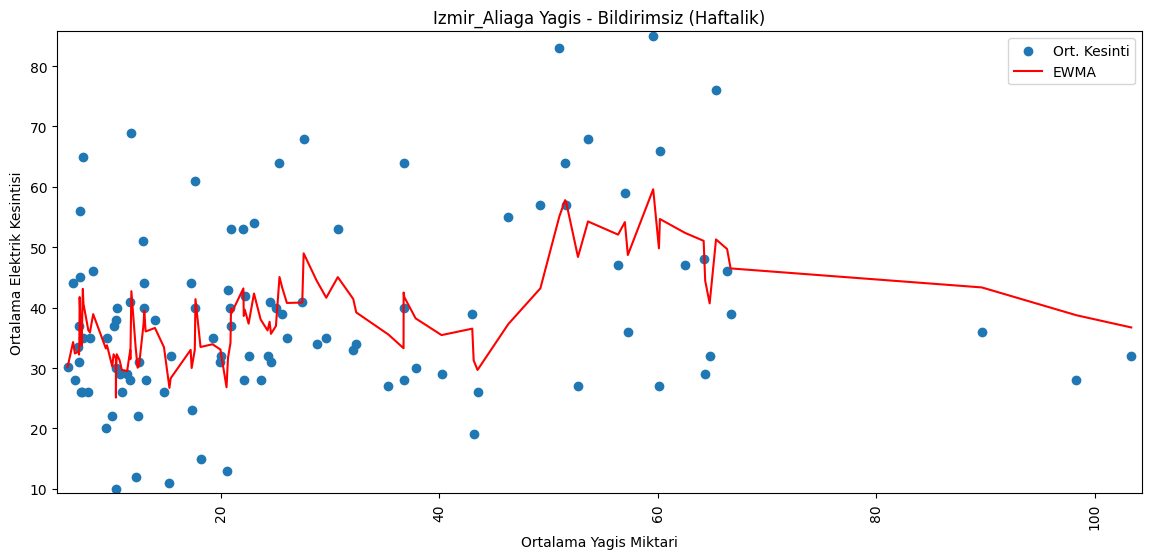

In [ ]:
# 9-) ort. yagis miktarlari icin ort. kesinti sayisi grafigi (cok mantikli, gerekli degil)

yagis_dict = {}
for label,group in merged_all_week["izmir-aliaga"].groupby("Yagis"):
    yagis_dict[label] = group

yagis_dict_toplamlari = {}
for deger in yagis_dict.keys():
    yagis_dict_toplamlari[deger] = yagis_dict[deger]["Bildirimsiz_sum"].mean()
print(yagis_dict_toplamlari)

hesaplamalar = pd.DataFrame(list(yagis_dict_toplamlari.items()), columns=['Ort. Yagis', 'Ort. Kesinti'])
print(hesaplamalar)
window_size = 3  # Hareketli ortalama penceresi
hesaplamalar['Moving_Average'] = hesaplamalar["Ort. Kesinti"].rolling(window=window_size, center=True).mean()

alpha = 0.3  # Yumuşatma parametresi 
# formul : EMA_t = α × X_t + (1 - α) × EMA_{t-1}
hesaplamalar['EWMA'] = hesaplamalar["Ort. Kesinti"].ewm(alpha=alpha, adjust=False).mean()


plt.figure(figsize=(14,6))
#plt.bar(merged_all_week["izmir-aliaga"]["Yagis"],merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=0.05, label="Bildirimsiz")
plt.scatter(yagis_dict_toplamlari.keys(), yagis_dict_toplamlari.values(), label="Ort. Kesinti")
#plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['Moving_Average'], label="MHO", color="red")
plt.plot(hesaplamalar["Ort. Yagis"], hesaplamalar['EWMA'], label="EWMA", color="red")
plt.margins(0.01)
plt.title("Izmir_Aliaga Yagis - Bildirimsiz (Haftalik)")
plt.xticks(rotation=90)
plt.xlabel("Ortalama Yagis Miktari")
plt.ylabel("Ortalama Elektrik Kesintisi")
plt.legend()
plt.show()

In [ ]:
# 10-) test icin birlestirme islemleri

test = pd.read_csv("./test.csv", low_memory=False) # 47 ilce icin 28 gunluk veriler var. (tarih, ilce, bildirimli_sum)
#print(test)

dict_test :{str, pd.DataFrame} = {} # key olarak ilceleri, value olarak ilcelerin 4 ocak - 31 ocak arasi verilerini df olarak tutar
for label, group in test.groupby("ilce"):
    dict_test[label] = group

print(dict_test["izmir-konak"].head())

for name in dict_test.keys():

    tarihler = [] # duzgun tarihleri tutacak
    for date in dict_test[name]["tarih"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d")) 

    dict_test[name]["tarih"] = tarihler # duzeltilmis tarihleri ata

    dict_test[name].set_index("tarih", inplace=True) # tarih kolonunu index'e ata
    dict_test[name]["Tarih"] = dict_test[name].index # tarih kolonunu yeniden olustur
    dict_test[name] = dict_test[name].iloc[:, [2, 0, 1]] # kolon siralarini duzenle
    dict_test[name].columns = ["Tarih", "Ilce", "Bildirimli_sum"] # kolon isimlerini duzenle

print(dict_test["izmir-konak"].head())


dict_test_merged = {} # birlestirilenleri tutacak dict
for name in dict_test.keys():

    gecici = merge_holiday(dict_test[name], holiday) # test'e holiday ekle
    dict_test_merged[name] = merge_weather(gecici, ilce_weather_day[name]) # sonra weather'i ekle

    dict_test_merged[name].columns = ["Tarih", "Ilce", "Bildirimli_sum", # kolonlari tekrar isimlendir
    "Bayram_Flag", "Sicaklik", "Bagil_Nem", "Ruzgar_Hizi", "Yagis"]

    dict_test_merged[name]['Gün'] = range(1, len(dict_test_merged[name]) + 1) # gun kolonu ekle (1-28 arasi oluyor)

print(dict_test_merged["izmir-konak"])


          tarih         ilce  bildirimli_sum
30   2024-01-04  izmir-konak               0
77   2024-01-05  izmir-konak               1
124  2024-01-06  izmir-konak               4
171  2024-01-07  izmir-konak               0
218  2024-01-08  izmir-konak               1
                Tarih         Ilce  Bildirimli_sum
tarih                                             
2024-01-04 2024-01-04  izmir-konak               0
2024-01-05 2024-01-05  izmir-konak               1
2024-01-06 2024-01-06  izmir-konak               4
2024-01-07 2024-01-07  izmir-konak               0
2024-01-08 2024-01-08  izmir-konak               1
                Tarih         Ilce  Bildirimli_sum Bayram_Flag   Sicaklik  \
tarih                                                                       
2024-01-04 2024-01-04  izmir-konak               0         NaN  14.104167   
2024-01-05 2024-01-05  izmir-konak               1         NaN  14.183333   
2024-01-06 2024-01-06  izmir-konak               4         NaN  1

MAKINE OGRENMESI

In [ ]:
#merged_all[]
df = merged_all['izmir-konak'] #ml icin hazir csv dosyasi
df_test = test #test csv birlestirilmis hazir dosyasi
features = ['bildirimli_sum','sicaklik vs'] #kalan ozellikler de yazilmali
output_var = df['bildirimsiz_sum']
target = 'bildirimsiz_sum'
ilceler = []

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group
ilceler = list(dict.keys())

KeyError: 'bildirimsiz_sum'

In [ ]:
# ilcelerin numerizasyonu -------- NEW olmasa da direkt sayilar olsa daha iyi olabilir
columns_tonumerate = ['ilce','BAYRAM_FLAG','vs vs.']
for column in columns_tonumerate:
    encoder = LabelEncoder()
    encode = encoder.fit_transform(df[column])
    df[column + '_NEW'] = encode #buraya _NEW eklemeli miyim tekrar bakmak gerek
    df.drop(columns=[column], inplace=True)

# csv dosyasi numerizasyon - sadece numarizasyon degil ayni zamanda weather ile birlestirme de yapilmali!!
for column in columns_tonumerate:
    encoder = LabelEncoder()
    encode = encoder.fit_transform(df_test[column])
    df_test[column + '_NEW'] = encode
    df_test.drop(columns=[column], inplace=True)

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()


# test.csv numerizasyonu da gerekiyor ayni sekilde

In [ ]:
# x-y test-train elde edimi
x = df[features]
y = output_var # = df["target_var"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=53, shuffle=True)

#Splitting to Training set and Test set --- burasi timeseries icin split
timesplit = TimeSeriesSplit(n_splits=15)
for train_index, test_index in timesplit.split(feature_transform):
        X_tr, X_te = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_tr, y_te = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
# LSTM

#Process the data for LSTM
trainX = np.array(X_tr)
testX = np.array(X_te)
X_tr = trainX.reshape(X_tr.shape[0], 1, X_tr.shape[1])
X_te = testX.reshape(X_te.shape[0], 1, X_te.shape[1])

#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

#Model Training
history=lstm.fit(X_tr, y_tr, epochs=100, batch_size=8, verbose=1, shuffle=False)

#LSTM Prediction
y_pr= lstm.predict(X_te)

# Predicted vs True Adj Close Value – LSTM  --burasi copy paste
plt.plot(y_te, label='True Value')
plt.plot(y_pr, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# test_pred = lstm.predict(gercek test)
# csv ye yazdir vs vs

In [ ]:
# KNN

X = df[features].values()
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=53, shuffle=True)

k=17
neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
neigh.fit(X_train, y_train)

y_hat = neigh.predict(X_test)

test_accuracy = neigh.score(X_test, y_test)

print("Test accuracy with class weights:", test_accuracy)
print("egitim verisi dogrulugu ", metrics.accuracy_score(y_train,neigh.predict(X_train)))
print("test verisi dogrulugu ", metrics.accuracy_score(y_test,y_hat))

# test tahmin
y_hat = neigh.predict(isteburayatestdosyasi)
submission = pd.read_csv("sample_submission.csv", low_memory=False)
submission.iloc[:, 1] = y_hat
# submission.to_csv("knnsubmission.csv", index=False)

# optimal k degeri

# # Define the range of k values to try
# k_values = range(1, 21)

# # Perform cross-validation for each value of k
# cv_scores = []
# for k in k_values:
#     neigh = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(neigh, X_train, y_train, cv=5)
#     cv_scores.append(scores.mean())

# # Find the optimal value of k with the highest cross-validation score
# optimal_k = k_values[cv_scores.index(max(cv_scores))]
# print("Optimal k:", optimal_k)

# # Train the model with the optimal k value
# neigh = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
# test_accuracy = neigh.score(X_test, y_test)
# print("Test accuracy with optimal k:", test_accuracy)
# print("")

In [ ]:
# NN
# alinan kaynakta goruntu isleme icin kullaniliyordu bazi uyusmazliklar olabilir
# Cast the records into float values 
# x_train = x_train.astype('float32') 
# x_test = x_test.astype('float32') 

print("Feature matrix:", x_train.shape) 
print("Target matrix:", x_test.shape) 
print("Feature matrix:", y_train.shape) 
print("Target matrix:", y_test.shape)  
model = Sequential([ 
    Flatten(input_shape=(x_train.shape)), 
    
    # dense layer 1 
    Dense(256, activation='sigmoid'),   
    
    # dense layer 2 
    Dense(128, activation='sigmoid'),  
    
    # output layer 
    Dense(10, activation='sigmoid'),   
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

model.fit(x_train, y_train, epochs=10,  
          batch_size=2000,  
          validation_split=0.2)

results = model.evaluate(x_test,  y_test, verbose = 0) 
print('test loss, test acc:', results)

Sequential() specifies that the network is a linear stack of layers

model.add() adds the hidden layer.

Dense means that neurons between layers are fully connected

input_dim defines the number of features in the training dataset

activation defines the activation function

loss selects the cost function

optimizer selects the learning algorithm

metrics selects the performance metrics to be saved for further analysis

model.fit() initialize the training

In [ ]:
# NN2

X = df[features] #features
y = df['target_var'] #expected values

model = Sequential()
model.add(Dense(16, input_dim=2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['binary_accuracy', 'mean_squared_error'])

history = model.fit(X, y, epochs=3000, verbose=0)

y_pred = model.predict(X).round()
num_correct_predictions = (y_pred == y).sum()
accuracy = (num_correct_predictions / y.shape[0]) * 100
print('Multi-layer perceptron accuracy: %.2f%%' % accuracy)